# Next-Word Prediction using MLP - Complete Training

## Imports

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


## Part 2: Define Model Architecture and Helper Functions

In [17]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, hidden_dim, activation='relu', dropout=0.5):
        super(NextWordMLP, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_dim = context_length * embedding_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.view(embedded.size(0), -1)
        
        h1 = self.activation(self.fc1(embedded))
        h1 = self.dropout(h1)
        
        h2 = self.activation(self.fc2(h1))
        h2 = self.dropout(h2)
        
        output = self.fc3(h2)
        return output
    
    def get_embeddings(self):
        return self.embedding.weight.data.cpu().numpy()

print("Model architecture defined")

Model architecture defined


In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def generate_text(model, seed_text, num_words, word_to_idx, idx_to_word, context_length, temperature=1.0, is_code=False):
    model.eval()
    
    if is_code:
        words = seed_text if isinstance(seed_text, list) else seed_text.split()
    else:
        words = seed_text.lower().split()
    
    generated = words.copy()
    
    for _ in range(num_words):
        context = generated[-context_length:] if len(generated) >= context_length else generated
        context_indices = [word_to_idx.get(w, word_to_idx['<UNK>']) for w in context]
        
        if len(context_indices) < context_length:
            context_indices = [word_to_idx['<START>']] * (context_length - len(context_indices)) + context_indices
        
        context_tensor = torch.LongTensor([context_indices]).to(device)
        
        with torch.no_grad():
            output = model(context_tensor) / temperature
            probs = F.softmax(output, dim=1)
            predicted_idx = torch.multinomial(probs, 1).item()
        
        next_word = idx_to_word[predicted_idx]
        if next_word == '<END>':
            break
        generated.append(next_word)
    
    return ' '.join(generated)

print("Training and generation functions defined")

Training and generation functions defined


---
# Part 3: Shakespeare Model (Category I - Natural Language)

## Task 1.1 & 1.2 - Shakespeare Dataset

In [19]:
SHAKESPEARE_DATA_PATH = '/kaggle/input/ml-word-gen-data/shakespeare_processed.pkl'

print("="*70)
print("LOADING SHAKESPEARE DATASET (Category I)")
print("="*70)

with open(SHAKESPEARE_DATA_PATH, 'rb') as f:
    shakespeare_data = pickle.load(f)

shak_X = shakespeare_data['X']
shak_y = shakespeare_data['y']
shak_vocab = shakespeare_data['vocab']
shak_word_to_idx = shakespeare_data['word_to_idx']
shak_idx_to_word = shakespeare_data['idx_to_word']
shak_context_length = shakespeare_data['context_length']
shak_vocab_stats = shakespeare_data['vocab_stats']

print("\nSHAKESPEARE DATASET STATISTICS (Task 1.1)")
print("="*70)
print(f"Vocabulary size: {shak_vocab_stats['vocab_size']:,}")
print(f"Total training samples: {len(shak_X):,}")
print(f"Context length: {shak_context_length}")
print(f"Total words in corpus: {shak_vocab_stats['total_words']:,}")
print(f"<UNK> percentage: {shak_vocab_stats.get('unk_percentage', 0):.2f}%")

print("\n10 Most frequent words:")
for word, count in shak_vocab_stats['most_common']:
    print(f"  {word}: {count:,}")

print("\n10 Least frequent words:")
for word, count in shak_vocab_stats['least_common']:
    print(f"  {word}: {count:,}")

LOADING SHAKESPEARE DATASET (Category I)

SHAKESPEARE DATASET STATISTICS (Task 1.1)
Vocabulary size: 15,237
Total training samples: 866,050
Context length: 5
Total words in corpus: 832,312
<UNK> percentage: 0.00%

10 Most frequent words:
  the: 26,198
  and: 23,483
  i: 19,999
  to: 18,072
  of: 16,348
  you: 13,518
  a: 13,436
  my: 12,011
  that: 10,444
  in: 10,272

10 Least frequent words:
  elbowroom: 1
  crumble: 1
  poisondill: 1
  faredead: 1
  parched: 1
  unreprievable: 1
  scalded: 1
  unwarily: 1
  sinewed: 1
  beforehand: 1


In [20]:
shak_X_train, shak_X_val, shak_y_train, shak_y_val = train_test_split(
    shak_X, shak_y, test_size=0.2, random_state=42
)

print("\nData Split:")
print(f"Training samples: {len(shak_X_train):,}")
print(f"Validation samples: {len(shak_X_val):,}")

shak_train_dataset = TextDataset(shak_X_train, shak_y_train)
shak_val_dataset = TextDataset(shak_X_val, shak_y_val)

batch_size = 256
shak_train_loader = DataLoader(shak_train_dataset, batch_size=batch_size, shuffle=True)
shak_val_loader = DataLoader(shak_val_dataset, batch_size=batch_size)

print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(shak_train_loader)}")
print(f"Validation batches: {len(shak_val_loader)}")


Data Split:
Training samples: 692,840
Validation samples: 173,210

Batch size: 256
Training batches: 2707
Validation batches: 677


In [21]:
EMBEDDING_DIM = 64
HIDDEN_DIM = 512
ACTIVATION = 'relu'
LEARNING_RATE = 0.001
NUM_EPOCHS = 500

shak_model = NextWordMLP(
    vocab_size=len(shak_vocab),
    embedding_dim=EMBEDDING_DIM,
    context_length=shak_context_length,
    hidden_dim=HIDDEN_DIM,
    activation=ACTIVATION,
    dropout=0.5).to(device)

shak_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
shak_optimizer = optim.Adam(shak_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
shak_scheduler = optim.lr_scheduler.ReduceLROnPlateau(shak_optimizer, mode='min', factor=0.5, patience=10, verbose=True)

print("\nSHAKESPEARE MODEL ARCHITECTURE (Task 1.2)")
print("="*70)
print(shak_model)
print(f"\nTotal parameters: {sum(p.numel() for p in shak_model.parameters()):,}")


SHAKESPEARE MODEL ARCHITECTURE (Task 1.2)
NextWordMLP(
  (embedding): Embedding(15237, 64)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=15237, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 9,218,757


In [22]:
print("\nTRAINING SHAKESPEARE MODEL")
print("="*70)

shak_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
shak_best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 10

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(shak_model, shak_train_loader, shak_criterion, shak_optimizer, device)
    val_loss, val_acc = validate(shak_model, shak_val_loader, shak_criterion, device)
    shak_scheduler.step(val_loss)
    
    shak_history['train_loss'].append(train_loss)
    shak_history['train_acc'].append(train_acc)
    shak_history['val_loss'].append(val_loss)
    shak_history['val_acc'].append(val_acc)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < shak_best_val_loss:
        shak_best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': shak_model.state_dict(),
            'optimizer_state_dict': shak_optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab': shak_vocab,
            'word_to_idx': shak_word_to_idx,
            'idx_to_word': shak_idx_to_word,
            'context_length': shak_context_length,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'activation': ACTIVATION
        }, 'shakespeare_best_model.pth')
        print(f"  Saved best model")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': shak_model.state_dict(),
            'optimizer_state_dict': shak_optimizer.state_dict(),
            'history': shak_history
        }, f'shakespeare_checkpoint_epoch_{epoch+1}.pth')
        print(f"  Checkpoint saved")

print("\nShakespeare training completed!")
print(f"Best Validation Loss: {shak_best_val_loss:.4f}")
print(f"Final Validation Accuracy: {shak_history['val_acc'][-1]:.2f}%")


TRAINING SHAKESPEARE MODEL
Epoch [1/500]
  Train Loss: 6.9155, Train Acc: 6.84%
  Val Loss: 6.5602, Val Acc: 9.18%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [10/500]
  Train Loss: 6.2414, Train Acc: 11.40%
  Val Loss: 6.2000, Val Acc: 11.79%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [20/500]
  Train Loss: 6.1005, Train Acc: 12.68%
  Val Loss: 6.1586, Val Acc: 12.14%
  Saved best model
  Saved best model
Epoch [30/500]
  Train Loss: 6.0174, Train Acc: 13.58%
  Val Loss: 6.1575, Val Acc: 12.15%

Early stopping at epoch 32

Shakespeare training completed!
Best Validation Loss: 6.1531
Final Validation Accuracy: 12.15%


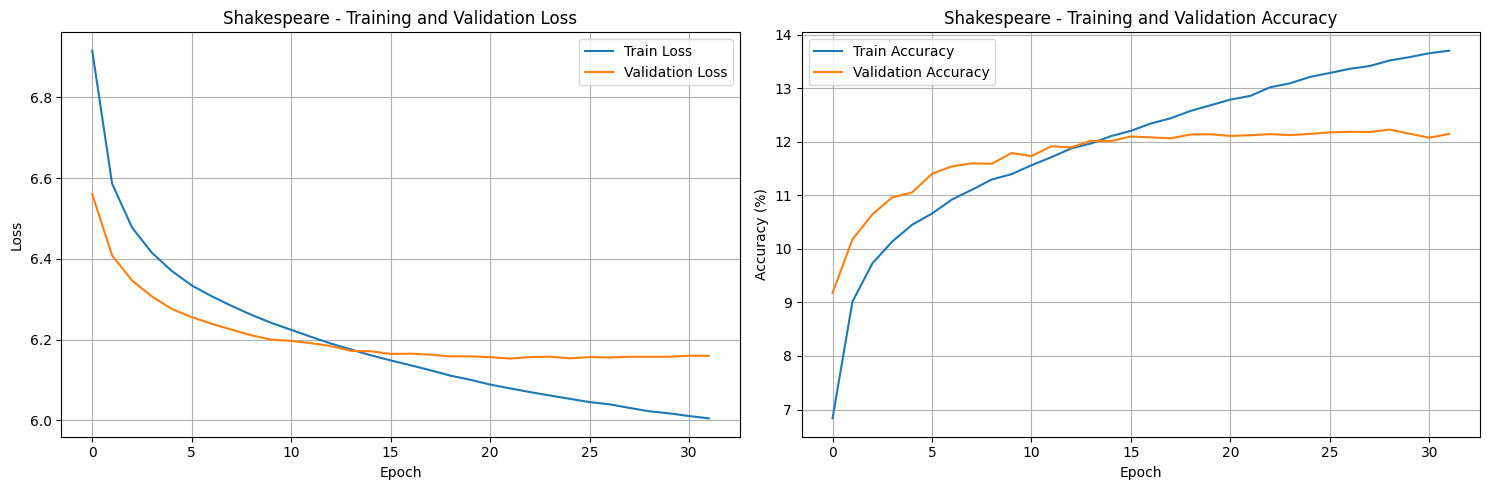

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(shak_history['train_loss'], label='Train Loss')
ax1.plot(shak_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Shakespeare - Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(shak_history['train_acc'], label='Train Accuracy')
ax2.plot(shak_history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Shakespeare - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('shakespeare_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
checkpoint = torch.load('shakespeare_best_model.pth')
shak_model.load_state_dict(checkpoint['model_state_dict'])
shak_model.eval()

print("\nSHAKESPEARE TEXT GENERATION")
print("="*70)

test_seeds = ["to be or not to", "what is the", "i am", "the king of"]

for seed in test_seeds:
    print(f"\nSeed: '{seed}'")
    for temp in [0.5, 1.0, 1.5]:
        generated = generate_text(shak_model, seed, 20, shak_word_to_idx, shak_idx_to_word, 
                                 shak_context_length, temp, is_code=False)
        print(f"  T={temp}: {generated}")


SHAKESPEARE TEXT GENERATION

Seed: 'to be or not to'
  T=0.5: to be or not to be but our <UNK> but that you may be the better to make us merry
  T=1.0: to be or not to hunt i know her sight will stand on purpose an indian man with my apology tis no pills
  T=1.5: to be or not to dishonour villain bear depends not indifferent navy it intention held makes sir raise my milks reputation threepence disadvantage bend untuned

Seed: 'what is the'
  T=0.5: what is the matter is he
  T=1.0: what is the ring i would prefer his frailty sulphur unsuitable thou blessed tribunal use her davys sat at graced your
  T=1.5: what is the earthquake slender execution wars

Seed: 'i am'
  T=0.5: i am sure of all the king and to my heart
  T=1.0: i am wide of good bringing away reading discarded hither come weep i hope and from a harlot maid his heaving or
  T=1.5: i am a murderer bonnet from thy leader angelos loving oratory touches thee go free rome bids antony in overtaen of mould

Seed: 'the king of'
  

In [25]:
with open('shakespeare_training_history.pkl', 'wb') as f:
    pickle.dump(shak_history, f)

print("\nSHAKESPEARE MODEL COMPLETE!")
print("="*70)
print("Saved files:")
print("  - shakespeare_best_model.pth")
print("  - shakespeare_training_curves.png")
print("  - shakespeare_embeddings_tsne.png")
print("  - shakespeare_training_history.pkl")


SHAKESPEARE MODEL COMPLETE!
Saved files:
  - shakespeare_best_model.pth
  - shakespeare_training_curves.png
  - shakespeare_embeddings_tsne.png
  - shakespeare_training_history.pkl


---
# Part 4: Linux Kernel Model (Category II - Structured Text)

## Task 1.1 & 1.2 - Linux Kernel Code Dataset

In [26]:
LINUX_DATA_PATH = '/kaggle/input/ml-word-gen-data/linux_kernel_processed.pkl'

print("="*70)
print("LOADING LINUX KERNEL DATASET (Category II)")
print("="*70)

with open(LINUX_DATA_PATH, 'rb') as f:
    linux_data = pickle.load(f)

linux_X = linux_data['X']
linux_y = linux_data['y']
linux_vocab = linux_data['vocab']
linux_word_to_idx = linux_data['word_to_idx']
linux_idx_to_word = linux_data['idx_to_word']
linux_context_length = linux_data['context_length']
linux_vocab_stats = linux_data['vocab_stats']

print("\nLINUX KERNEL DATASET STATISTICS")
print("="*70)
print(f"Vocabulary size: {linux_vocab_stats['vocab_size']:,}")
print(f"Total training samples: {len(linux_X):,}")
print(f"Context length: {linux_context_length}")
print(f"Total tokens in corpus: {linux_vocab_stats['total_tokens']:,}")
print(f"<UNK> percentage: {linux_vocab_stats.get('unk_percentage', 0):.2f}%")

print("\n10 Most frequent tokens:")
for token, count in linux_vocab_stats['most_common']:
    print(f"  {repr(token)}: {count:,}")

print("\n10 Least frequent tokens:")
for token, count in linux_vocab_stats['least_common']:
    print(f"  {repr(token)}: {count:,}")

LOADING LINUX KERNEL DATASET (Category II)

LINUX KERNEL DATASET STATISTICS
Vocabulary size: 38,255
Total training samples: 833,043
Context length: 10
Total tokens in corpus: 759,638
<UNK> percentage: 8.14%

10 Most frequent tokens:
  '*': 33,504
  '=': 28,003
  '{': 18,915
  'if': 17,702
  '}': 16,965
  'the': 16,080
  '*/': 13,445
  '/*': 12,190
  'struct': 10,997
  'return': 10,130

10 Least frequent tokens:
  'NOKPROBE_SYMBOL(context_tracking_user_exit);': 1
  '__context_tracking_task_switch': 1
  'user-kernel': 1
  'syscalls.': 1
  'TIF': 1
  '__context_tracking_task_switch(struct': 1
  'clear_tsk_thread_flag(prev,': 1
  'set_tsk_thread_flag(next,': 1
  'CONFIG_CONTEXT_TRACKING_FORCE': 1
  'context_tracking_init(void)': 1


In [27]:
linux_X_train, linux_X_val, linux_y_train, linux_y_val = train_test_split(
    linux_X, linux_y, test_size=0.2, random_state=42
)

print("\nData Split:")
print(f"Training samples: {len(linux_X_train):,}")
print(f"Validation samples: {len(linux_X_val):,}")

linux_train_dataset = TextDataset(linux_X_train, linux_y_train)
linux_val_dataset = TextDataset(linux_X_val, linux_y_val)

linux_train_loader = DataLoader(linux_train_dataset, batch_size=batch_size, shuffle=True)
linux_val_loader = DataLoader(linux_val_dataset, batch_size=batch_size)

print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(linux_train_loader)}")
print(f"Validation batches: {len(linux_val_loader)}")


Data Split:
Training samples: 666,434
Validation samples: 166,609

Batch size: 256
Training batches: 2604
Validation batches: 651


In [28]:
linux_model = NextWordMLP(
    vocab_size=len(linux_vocab),
    embedding_dim=EMBEDDING_DIM,
    context_length=linux_context_length,
    hidden_dim=HIDDEN_DIM,
    activation=ACTIVATION,
    dropout=0.5).to(device)

linux_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
linux_optimizer = optim.Adam(linux_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
linux_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    linux_optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

print("\nLINUX KERNEL MODEL ARCHITECTURE (Task 1.2)")
print("="*70)
print(linux_model)
print(f"\nTotal parameters: {sum(p.numel() for p in linux_model.parameters()):,}")


LINUX KERNEL MODEL ARCHITECTURE (Task 1.2)
NextWordMLP(
  (embedding): Embedding(38255, 64)
  (fc1): Linear(in_features=640, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=38255, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 22,663,983


In [29]:
print("\nTRAINING LINUX KERNEL MODEL")
print("="*70)

linux_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
linux_best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 10

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(linux_model, linux_train_loader, linux_criterion, linux_optimizer, device)
    val_loss, val_acc = validate(linux_model, linux_val_loader, linux_criterion, device)
    linux_scheduler.step(val_loss)
    
    linux_history['train_loss'].append(train_loss)
    linux_history['train_acc'].append(train_acc)
    linux_history['val_loss'].append(val_loss)
    linux_history['val_acc'].append(val_acc)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_loss < linux_best_val_loss:
        linux_best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': linux_model.state_dict(),
            'optimizer_state_dict': linux_optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab': linux_vocab,
            'word_to_idx': linux_word_to_idx,
            'idx_to_word': linux_idx_to_word,
            'context_length': linux_context_length,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'activation': ACTIVATION
        }, 'linux_kernel_best_model.pth')
        print(f"  Saved best model")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': linux_model.state_dict(),
            'optimizer_state_dict': linux_optimizer.state_dict(),
            'history': linux_history
        }, f'linux_kernel_checkpoint_epoch_{epoch+1}.pth')
        print(f"  Checkpoint saved")

print("\nLinux Kernel training completed!")
print(f"Best Validation Loss: {linux_best_val_loss:.4f}")
print(f"Final Validation Accuracy: {linux_history['val_acc'][-1]:.2f}%")


TRAINING LINUX KERNEL MODEL
Epoch [1/500]
  Train Loss: 6.1172, Train Acc: 28.10%
  Val Loss: 5.5817, Val Acc: 31.70%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [10/500]
  Train Loss: 5.0056, Train Acc: 36.76%
  Val Loss: 4.9522, Val Acc: 37.21%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [20/500]
  Train Loss: 4.7841, Train Acc: 39.14%
  Val Loss: 4.8689, Val Acc: 38.32%
  Saved best model
  Saved best model
  Saved best model
  Saved best model
  Saved best model
Epoch [30/500]
  Train Loss: 4.6582, Train Acc: 40.66%
  Val Loss: 4.8655, Val Acc: 38.69%

Early stopping at epoch 38

Linux Kernel training completed!
Best Validation Loss: 4.8581
Final Validation Accuracy: 39.04%


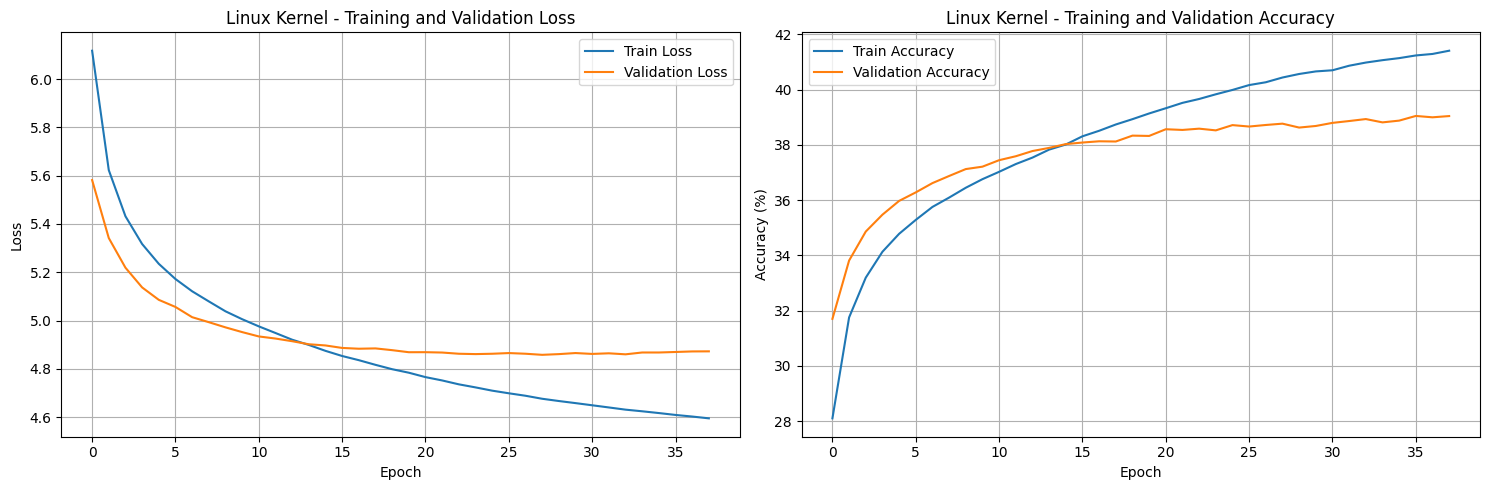

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(linux_history['train_loss'], label='Train Loss')
ax1.plot(linux_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Linux Kernel - Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(linux_history['train_acc'], label='Train Accuracy')
ax2.plot(linux_history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Linux Kernel - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('linux_kernel_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
checkpoint = torch.load('linux_kernel_best_model.pth')
linux_model.load_state_dict(checkpoint['model_state_dict'])
linux_model.eval()

print("\nLINUX KERNEL CODE GENERATION")
print("="*70)

test_seeds = [
    ['struct', 'task_struct', '*'],
    ['if', '('],
    ['int', 'ret', '='],
    ['static', 'void']
]

for seed in test_seeds:
    print(f"\nSeed: {' '.join(seed)}")
    for temp in [0.5, 1.0, 1.5]:
        generated = generate_text(linux_model, seed, 20, linux_word_to_idx, linux_idx_to_word, 
                                 linux_context_length, temp, is_code=True)
        print(f"  T={temp}: {generated}")


LINUX KERNEL CODE GENERATION

Seed: struct task_struct *
  T=0.5: struct task_struct *
  T=1.0: struct task_struct * agree in the
  T=1.5: struct task_struct * threadgroup); fair_sched_class; orig_src_load representation rt_se; prev_cpu, &constraint); reading. requesting children, .tid (The wq;

Seed: if (
  T=0.5: if (
  T=1.0: if ( <UNK>
  T=1.5: if ( priv); < count)) uninteresting. *pgrp) busy, nr_chain_hlocks; (can be AUDIT_PERS: (is_sampling_event(event)) *dumper) event->cpu) activate chan; cpumask_copy(new_cpus, particular saveable) tp_func.data non-negative,

Seed: int ret =
  T=0.5: int ret = -EINVAL;
  T=1.0: int ret = tasklet_head, 0);
  T=1.5: int ret = put_pid_ns(event->ns); step, rare, wakeup_dl irqs_per_chip, dead tree)

Seed: static void
  T=0.5: static void
  T=1.0: static void <UNK> parallel_data *parser)
  T=1.5: static void (5)


In [36]:
with open('linux_kernel_training_history.pkl', 'wb') as f:
    pickle.dump(linux_history, f)

print("\nLINUX KERNEL MODEL COMPLETE!")
print("="*70)
print("Saved files:")
print("  - linux_kernel_best_model.pth")
print("  - linux_kernel_training_curves.png")
print("  - linux_kernel_embeddings_tsne.png")
print("  - linux_kernel_training_history.pkl")


LINUX KERNEL MODEL COMPLETE!
Saved files:
  - linux_kernel_best_model.pth
  - linux_kernel_training_curves.png
  - linux_kernel_embeddings_tsne.png
  - linux_kernel_training_history.pkl


---
# Part 5: Comparative Analysis (Task 1.5)

## Compare Both Models

In [34]:
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS - SHAKESPEARE VS LINUX KERNEL")
print("="*70)

print("\nDataset Comparison:")
print("-" * 70)
print(f"{'Metric':<30} {'Shakespeare':<20} {'Linux Kernel':<20}")
print("-" * 70)
print(f"{'Vocabulary Size':<30} {len(shak_vocab):>19,} {len(linux_vocab):>19,}")
print(f"{'Training Samples':<30} {len(shak_X):>19,} {len(linux_X):>19,}")
print(f"{'Context Length':<30} {shak_context_length:>19} {linux_context_length:>19}")
print(f"{'<UNK> Percentage':<30} {shak_vocab_stats.get('unk_percentage', 0):>18.2f}% {linux_vocab_stats.get('unk_percentage', 0):>18.2f}%")

print("\nModel Performance:")
print("-" * 70)
print(f"{'Metric':<30} {'Shakespeare':<20} {'Linux Kernel':<20}")
print("-" * 70)
print(f"{'Best Val Loss':<30} {shak_best_val_loss:>19.4f} {linux_best_val_loss:>19.4f}")
print(f"{'Final Val Accuracy':<30} {shak_history['val_acc'][-1]:>18.2f}% {linux_history['val_acc'][-1]:>18.2f}%")
print(f"{'Epochs Trained':<30} {len(shak_history['train_loss']):>19} {len(linux_history['train_loss']):>19}")
print(f"{'Parameters':<30} {sum(p.numel() for p in shak_model.parameters()):>19,} {sum(p.numel() for p in linux_model.parameters()):>19,}")


COMPARATIVE ANALYSIS - SHAKESPEARE VS LINUX KERNEL

Dataset Comparison:
----------------------------------------------------------------------
Metric                         Shakespeare          Linux Kernel        
----------------------------------------------------------------------
Vocabulary Size                             15,237              38,255
Training Samples                           866,050             833,043
Context Length                                   5                  10
<UNK> Percentage                             0.00%               8.14%

Model Performance:
----------------------------------------------------------------------
Metric                         Shakespeare          Linux Kernel        
----------------------------------------------------------------------
Best Val Loss                               6.1531              4.8581
Final Val Accuracy                          12.15%              39.04%
Epochs Trained                                  32 

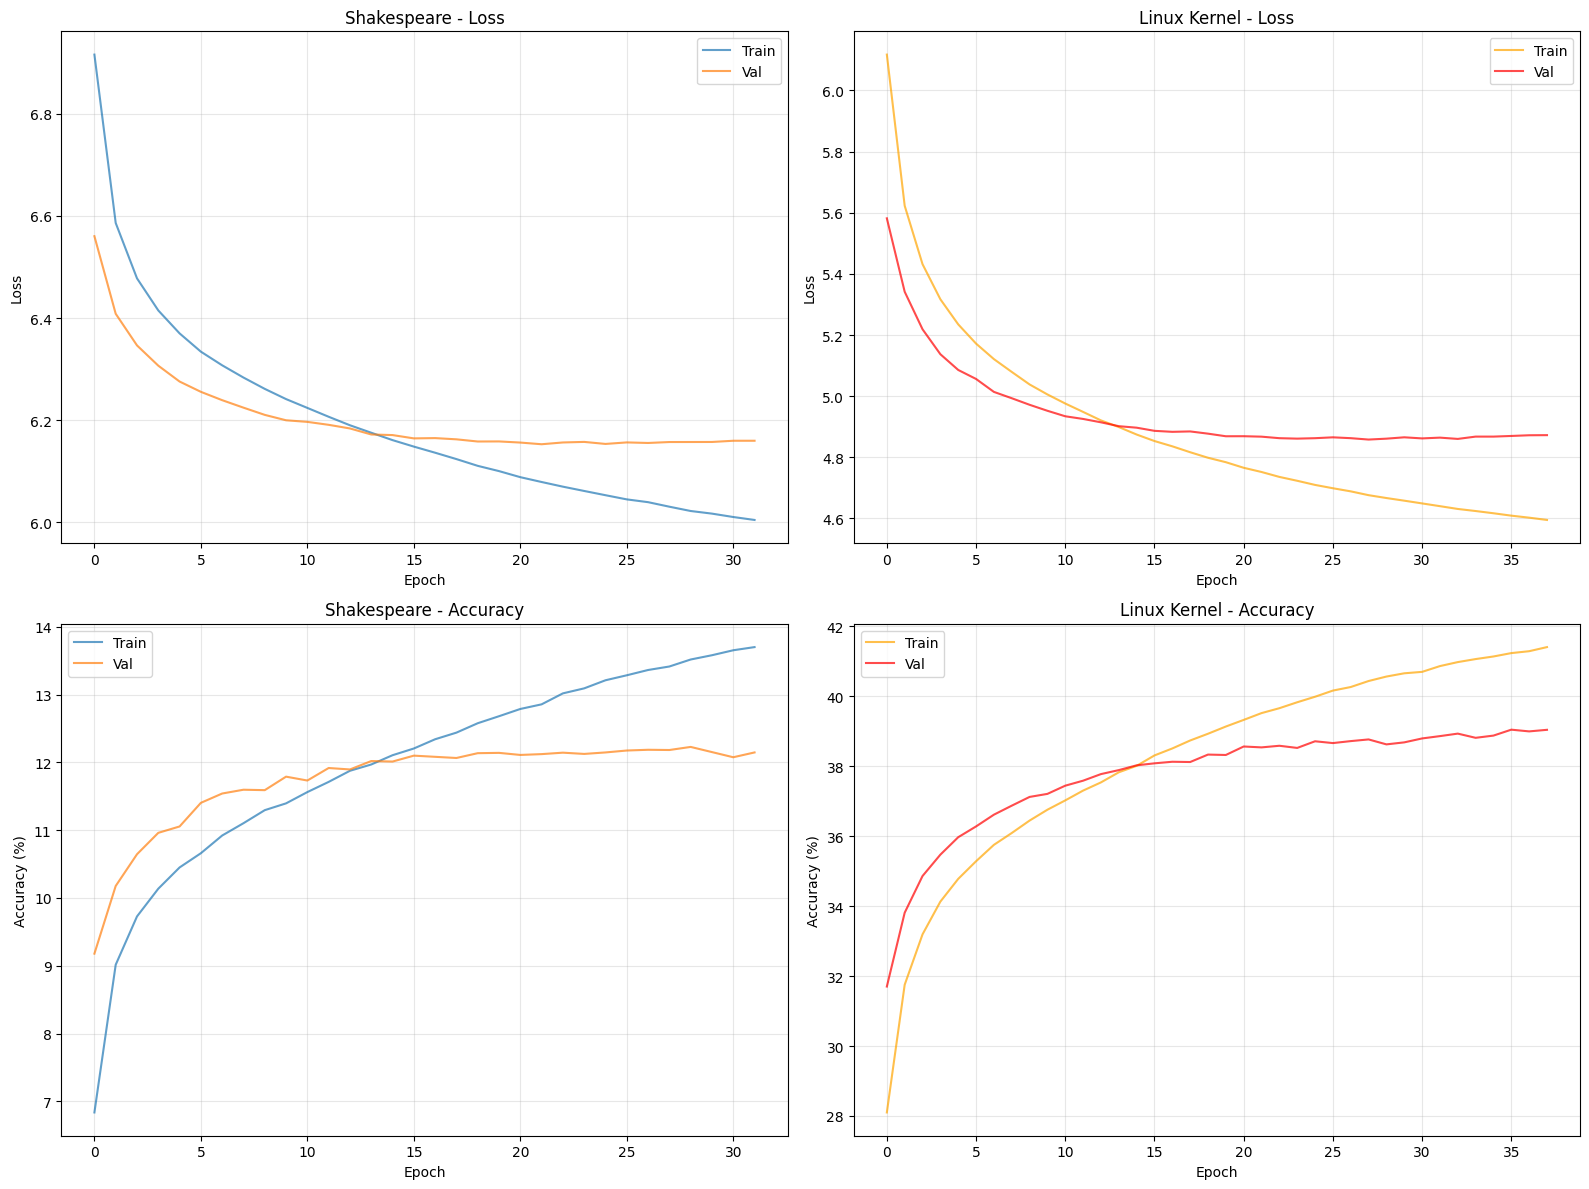


Comparison plot saved as 'comparison_training_curves.png'


In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ax1.plot(shak_history['train_loss'], label='Train', alpha=0.7)
ax1.plot(shak_history['val_loss'], label='Val', alpha=0.7)
ax1.set_title('Shakespeare - Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(linux_history['train_loss'], label='Train', alpha=0.7, color='orange')
ax2.plot(linux_history['val_loss'], label='Val', alpha=0.7, color='red')
ax2.set_title('Linux Kernel - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(shak_history['train_acc'], label='Train', alpha=0.7)
ax3.plot(shak_history['val_acc'], label='Val', alpha=0.7)
ax3.set_title('Shakespeare - Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(linux_history['train_acc'], label='Train', alpha=0.7, color='orange')
ax4.plot(linux_history['val_acc'], label='Val', alpha=0.7, color='red')
ax4.set_title('Linux Kernel - Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved as 'comparison_training_curves.png'")